# Dependencies

In [1]:
import os
import sys
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image


import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


# Data 🖼️
# Discover our classes

In [3]:
data_dir = "Teeth_Dataset"
train_dir = os.path.join(data_dir, "Training")
val_dir = os.path.join(data_dir, "Validation")

In [4]:
train_classes = os.listdir(train_dir)
val_classes = os.listdir(val_dir)

print(train_classes)
print(train_classes == val_classes)

['OT', 'CoS', 'MC', 'Gum', 'OC', 'CaS', 'OLP']
True


In [5]:
def visualize_distribution(classes, dir, name):
    classes_dist = {}
    for cls in classes:
        path = os.path.join(dir, cls)
        class_imgs = os.listdir(path)
        classes_dist[cls] = len(class_imgs)

    classes_dist = dict(sorted(classes_dist.items(), key=lambda item: item[1]))
    names = list(classes_dist.keys())
    values = list(classes_dist.values())

    plt.figure(figsize=(10, 6))
    bars = plt.barh(names, values, color='skyblue' if name=='Training' else 'orchid', edgecolor='black')

    for bar in bars:
        plt.text(bar.get_width() / 2, 
                 bar.get_y() + bar.get_height() / 2, 
                 str(int(bar.get_width())), 
                 ha='center', va='center', 
                 fontsize=12, fontweight='bold', 
                 color='white')  

    plt.xlabel("Number of Images", fontsize=14)
    plt.ylabel("Classes", fontsize=14)
    plt.title(f"{name} Class Distribution", fontsize=16, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    plt.show()


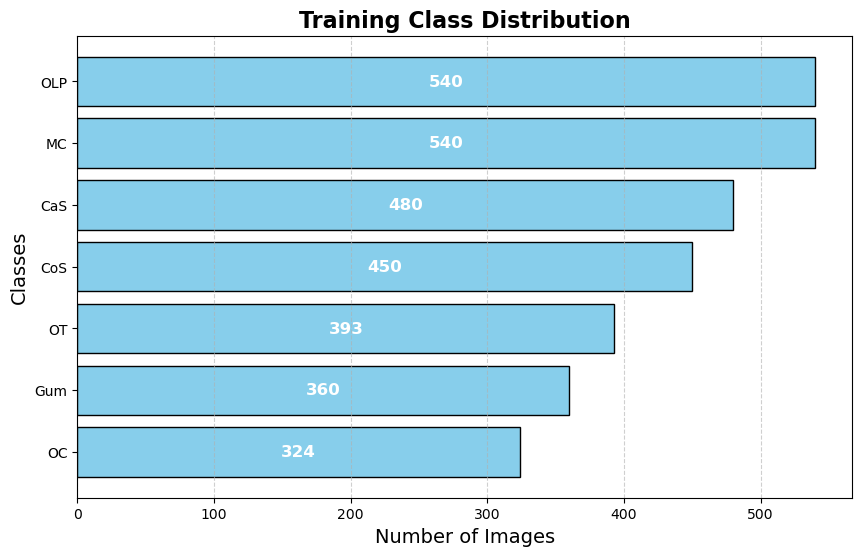

In [6]:
visualize_distribution(train_classes, train_dir, "Training")

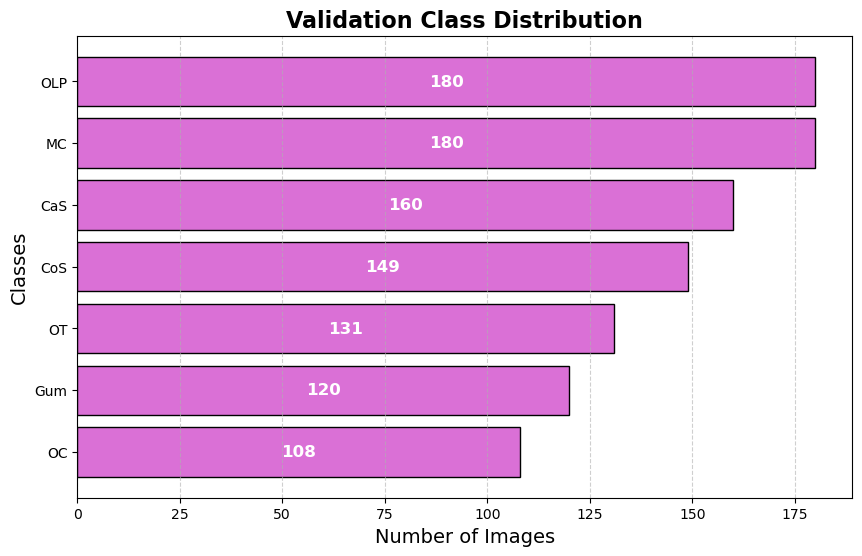

In [7]:
visualize_distribution(val_classes, val_dir, "Validation")

# Visualize some images

In [8]:
def visualize_image(img_class):

    class_path = os.path.join(train_dir, img_class)

    class_images = os.listdir(class_path)
    image_name = random.choice(class_images)

    image_path = os.path.join(class_path, image_name)
    
    image_pil = Image.open(image_path) # pillow image 

    plt.figure(figsize=(5,5))
    plt.imshow(image_pil)
    plt.axis("off")  
    plt.title(f"Random Image from {img_class} class")
    plt.show()

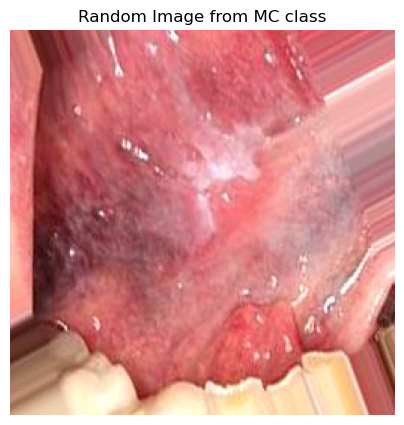

In [9]:
visualize_image("MC")

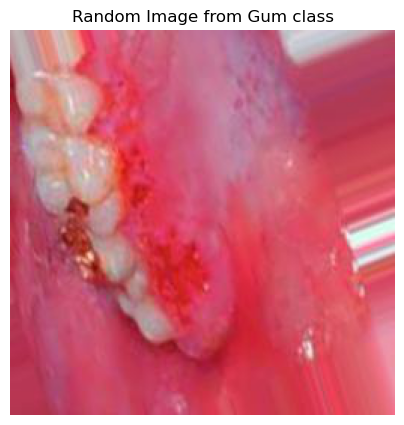

In [10]:
visualize_image("Gum")

# 📌Preprocessing and Augmentation
- Convert to tensors.
- Normalize (divide by 255). 
- Resize (**for later use** to be compatible with pretrained models).
- Augmentations (which will help our model to **generalize** well on testing and real-world images), this includes:
    - Crop.
    - Rotation.
    - Flip.

- Visualize before and after.

In [11]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), # This converts images to tensors and normalize to [0,1]
        transforms.RandomResizedCrop(size=256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        
    ]
)

In [12]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

print(train_dataset)
print("-"*50)
print(val_dataset)

Dataset ImageFolder
    Number of datapoints: 3087
    Root location: Teeth_Dataset/Training
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
           )
--------------------------------------------------
Dataset ImageFolder
    Number of datapoints: 1028
    Root location: Teeth_Dataset/Validation
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
           )


In [13]:
print(train_dataset.classes)
print(val_dataset.classes)

['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


In [14]:
print(f"Length of training set: {len(train_dataset)}")

print(f"Length of validation set: {len(val_dataset)}")


Length of training set: 3087
Length of validation set: 1028


In [15]:
im = train_dataset.imgs
print(im[0])

distinct_classes = {im[i][1] for i in range(len(im))}
print(distinct_classes)

('Teeth_Dataset/Training/CaS/a_100_0_1462.jpg', 0)
{0, 1, 2, 3, 4, 5, 6}


In [16]:
g = torch.Generator()
g.manual_seed(42)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=g)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

image_shape = images.shape
print("Shape of batch of images", image_shape)

label_shape = labels.shape
print("Shape of batch of labels:", label_shape)

Shape of batch of images torch.Size([32, 3, 256, 256])
Shape of batch of labels: torch.Size([32])


# 📌Model

- Build and train.
- Test on some images.
- Build a more complex model.

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.fc1 = nn.Linear(128 * 32 * 32, 256)  
        self.fc2 = nn.Linear(256, num_classes)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten for FC layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  
        return x

In [19]:
num_classes = len(train_loader.dataset.classes)  
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc, val_loss = evaluate_model(model, val_loader)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

def evaluate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total, val_loss / len(val_loader)


In [22]:
train_model(model, train_loader, val_loader, epochs=200)

Epoch [1/200], Loss: 2.0549, Train Acc: 17.30%, Val Loss: 1.9198, Val Acc: 17.61%
Epoch [2/200], Loss: 1.8915, Train Acc: 22.64%, Val Loss: 1.8387, Val Acc: 25.78%
Epoch [3/200], Loss: 1.8222, Train Acc: 26.40%, Val Loss: 1.7758, Val Acc: 30.84%
Epoch [4/200], Loss: 1.7864, Train Acc: 29.02%, Val Loss: 1.6719, Val Acc: 35.41%
Epoch [5/200], Loss: 1.7299, Train Acc: 32.10%, Val Loss: 1.6538, Val Acc: 35.21%
Epoch [6/200], Loss: 1.7042, Train Acc: 33.04%, Val Loss: 1.6770, Val Acc: 34.53%
Epoch [7/200], Loss: 1.6252, Train Acc: 39.00%, Val Loss: 1.6014, Val Acc: 38.13%
Epoch [8/200], Loss: 1.5646, Train Acc: 39.84%, Val Loss: 1.5567, Val Acc: 43.77%
Epoch [9/200], Loss: 1.5371, Train Acc: 41.27%, Val Loss: 1.4558, Val Acc: 47.08%
Epoch [10/200], Loss: 1.4717, Train Acc: 46.16%, Val Loss: 1.4562, Val Acc: 45.04%
Epoch [11/200], Loss: 1.4402, Train Acc: 46.26%, Val Loss: 1.4709, Val Acc: 44.65%
Epoch [12/200], Loss: 1.3847, Train Acc: 49.17%, Val Loss: 1.3876, Val Acc: 48.93%
Epoch [13/200

save the model

In [23]:
scripted_model = torch.jit.script(model)
scripted_model.save("teeth_disease_model.pt")

# 📌Testing 
- Test on the test set.
- Test on some images.

## Testing on the test set

Prepare the test set

In [24]:
test_dir = os.path.join(data_dir, "Testing")
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_classes = train_classes

In [25]:
accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
precision = Precision(task="multiclass", num_classes=num_classes, average="macro").to(device)
recall = Recall(task="multiclass", num_classes=num_classes, average="macro").to(device)
f1 = F1Score(task="multiclass", num_classes=num_classes, average="macro").to(device)

In [26]:
def evaluate_model(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.append(predicted)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc = accuracy(all_preds, all_labels).item()
    prec = precision(all_preds, all_labels).item()
    rec = recall(all_preds, all_labels).item()
    f1_score = f1(all_preds, all_labels).item()

    print(f"📊 Evaluation Results:")
    print(f"✅ Accuracy: {acc:.2%}")
    print(f"✅ Precision: {prec:.2%}")
    print(f"✅ Recall: {rec:.2%}")
    print(f"✅ F1-Score: {f1_score:.2%}")

In [27]:
evaluate_model(model, test_loader)

📊 Evaluation Results:
✅ Accuracy: 81.42%
✅ Precision: 82.80%
✅ Recall: 81.39%
✅ F1-Score: 81.64%


## Testing on individual images

In [28]:
def preprocess_image(image):
    image = Image.open(image).convert("RGB")
    image = transform(image).unsqueeze(0)
    return image.to(device)

def test_random_image(dir, classes):

    img_class = random.choice(os.listdir(dir)) 
    class_path = os.path.join(dir, img_class)

    class_images = os.listdir(class_path)
    image_name = random.choice(class_images)

    image_path = os.path.join(class_path, image_name)
    image_pil = Image.open(image_path) # pillow image 
    image_tensor = preprocess_image(image_path)

    output = model(image_tensor)
    prediction = torch.argmax(output, dim=1).item()
    pred_class = classes[prediction]

    plt.figure(figsize=(5,5))
    plt.imshow(image_pil)
    plt.axis("off")  
    plt.title(f"Actual Class: {img_class}   Predicted Class: {pred_class}")
    plt.show()

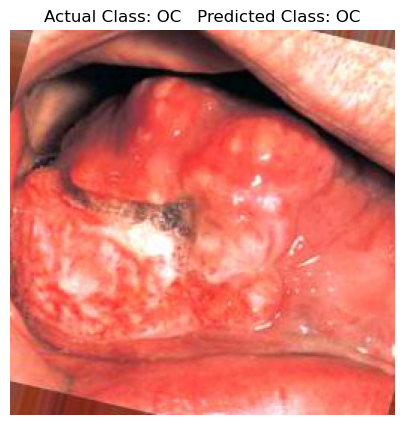

In [32]:
test_random_image(test_dir, test_classes)